## 简单估计

以下数据演示了目标先静止后匀速运动。观测的数据是有误差的。

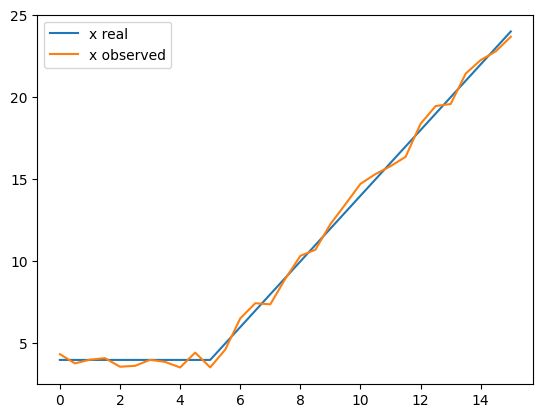

In [1]:
import matplotlib.pyplot as plt
import numpy as np
# set numpy default dtype to float32


M = 10
N = 31
v_real = np.array([0.] * M + [2.] * (N - M))
# add some noise
t = np.linspace(0, 15, N)
x_real = np.zeros(N)

x_real[0] = 4
for i in range(1, N):
    x_real[i] = x_real[i - 1] + v_real[i - 1] * (t[i] - t[i - 1])
x_obs = x_real + np.random.normal(0, 0.3, N)

# plot them


def plot_tuple(tup_xyname):
    for x, y, name in tup_xyname:
        plt.plot(x, y, label=name)
    plt.legend()
    plt.show()


plot_tuple([(t, x_real, 'x real'), (t, x_obs, 'x observed')])

用平均法估计位置，平滑但滞后，且不会收敛。

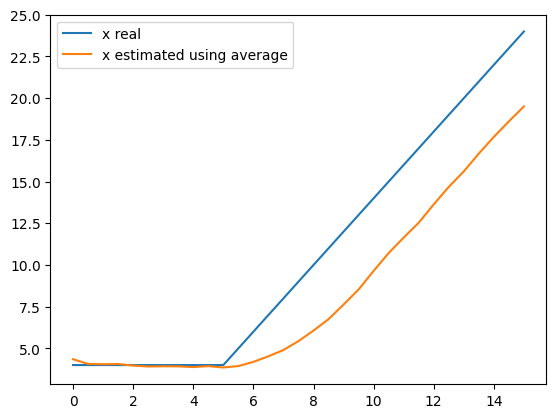

In [2]:
# 用平均法估计位置
K = 10


def moving_ave(x, i, k):
    if i < k:
        return np.mean(x[:i + 1])
    return np.mean(x[i - k + 1:i + 1])


x_esti = [moving_ave(x_obs, i, K) for i in range(N)]
plot_tuple([(t, x_real, 'x real'), (t, x_esti, 'x estimated using average')])

用帧差法估计速度，非常不平滑。

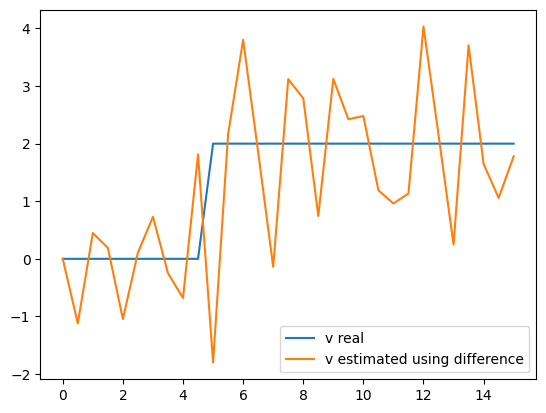

In [3]:
# 使用帧差法估计速度
v_esti_dif = [0] + [(x_obs[i] - x_obs[i - 1]) / (t[i] - t[i - 1])
                    for i in range(1, len(x_obs))]
plot_tuple(
    [(t, v_real, 'v real'), (t, v_esti_dif, 'v estimated using difference')])

用平均帧差法估计速度，相对平滑但滞后。

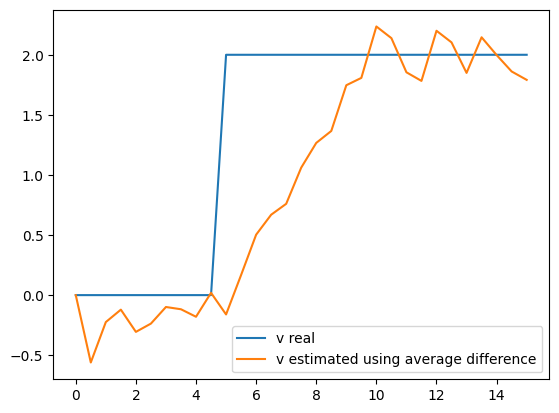

In [4]:
# 平均帧差法估计速度
v_esti_dif_ave = [moving_ave(v_esti_dif, i, K) for i in range(N)]
plot_tuple([(t, v_real, 'v real'), (t, v_esti_dif_ave,
           'v estimated using average difference')])

使用卡尔曼滤波估计，根据经验数值调节 $P$ 和 $Q$，即可同时得到位置和速度的估计，其较为平滑且滞后较少，最终可收敛于正确值。

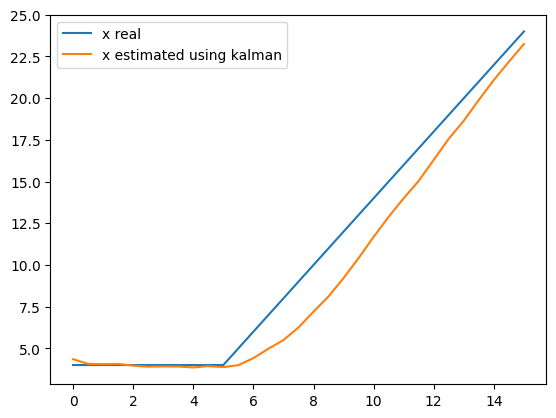

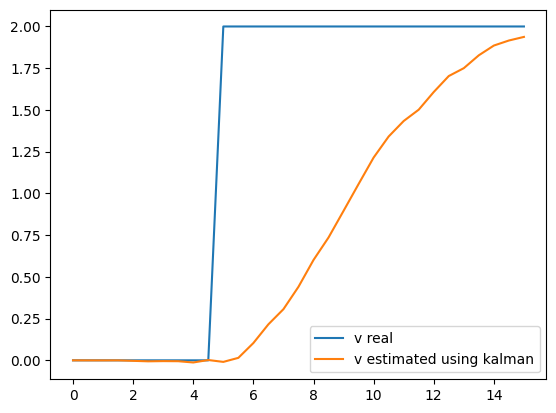

In [ ]:
class Kalman:
    def __init__(self, x, P, H):
        self.x = x  # [state * 1]
        self.P = P  # [state * state]
        self.H = H  # [obs * state]

    def predict(self, F, Q):
        self.x = F @ self.x
        self.P = F @ self.P @ F.T + Q

    def update(self, z, R):
        y = z - self.H @ self.x
        S = self.H @ self.P @ self.H.T + R
        K = self.P @ self.H.T @ np.linalg.inv(S)
        self.x = self.x + K @ y
        self.P = self.P - K @ self.H @ self.P


# 注意 P 初值的设定，若不能确定状态处置，则将方差设为仅位置项为极大值
kalman = Kalman(np.array([0, 0]), P=np.array(
    [[1e6, 0], [0, 0]]), H=np.array([[1, 0]]))
pos_v_kalman = []
for i in range(N):
    kalman.predict(F=np.array(
        [[1, t[i] - t[i - 1] if i > 0 else 0], [0, 1]]), Q=np.array([[0.1, 0], [0, 10]]))
    kalman.update(z=np.array([x_obs[i]]), R=np.eye(1) * 50)
    pos_v_kalman.append(kalman.x)

plot_tuple([(t, x_real, 'x real'), (t, [x[0]
           for x in pos_v_kalman], 'x estimated using kalman')])
plot_tuple([(t, v_real, 'v real'), (t, [x[1]
           for x in pos_v_kalman], 'v estimated using kalman')])

In [6]:
import torch
from torch.autograd.functional import jacobian


class Ekf:
    def __init__(self, x, P, measure_func):
        self.x = x  # [state * 1]
        self.P = P  # [state * state]
        self.measure_func = measure_func

    def predict(self, predict_func, Q):
        self.x = predict_func(self.x)
        F = jacobian(predict_func, self.x)
        self.P = F @ self.P @ F.T + Q

    def update(self, z, R):
        y = z - self.measure_func(self.x)
        H = jacobian(self.measure_func, self.x)
        S = H @ self.P @ H.T + R
        K = self.P @ H.T @ torch.inverse(S)
        self.x = self.x + K @ y
        self.P = self.P - K @ H @ self.P

ModuleNotFoundError: No module named 'torch'

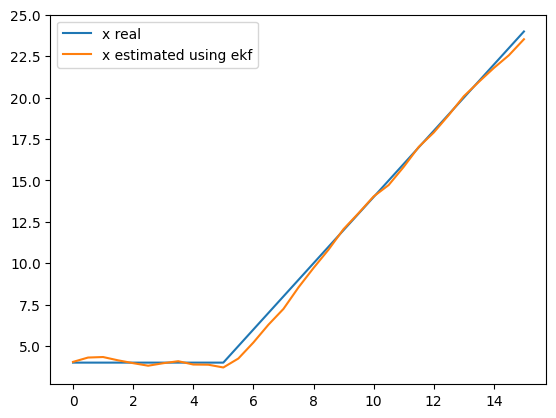

In [13]:
# 保持 x[0] 单元素的额外一个维度; 输入 x shape 为 (2,) 而不是 (2, 1)
ekf = Ekf(torch.tensor([0., 0.]), torch.tensor(
    [[1e6, 0], [0, 0]]), lambda x: torch.stack((x[0], )))
pos_v_ekf = []
for i in range(N):
    ekf.predict(
        predict_func=lambda x: torch.stack(
            (x[0] + x[1] * (t[i] - t[i - 1]), x[1])),
        Q=torch.tensor([[0.1, 0], [0, 10]])
    )
    ekf.update(z=torch.tensor(
        [x_obs[i]], dtype=torch.float32), R=torch.eye(1) * 50.0)
    pos_v_ekf.append(ekf.x)
plot_tuple([(t, x_real, 'x real'), (t, [x[0].item()
           for x in pos_v_ekf], 'x estimated using ekf')])

In [9]:
GM = 1
pos_real = [np.array([0., 1])]
v_real = [np.array((1.3, -0.2))]
t_real = [0]
sim_t = 0.01
N = 1500
damp = 0.99999
# GM 引力下自由运动
for i in range(1, N):
    t_real.append(t_real[i - 1] + sim_t)
    a = -GM * pos_real[-1] / np.linalg.norm(pos_real[-1]) ** 3
    v_real.append((v_real[-1] + a * sim_t) * damp)
    # x += (v + v') / 2 * t
    pos_real.append(pos_real[-1] + (v_real[-1] + v_real[-2]) / 2 * sim_t)


def plot2d(pos):
    # plot with changing color
    colors = plt.cm.jet(np.linspace(0, 1, len(pos)))[::-1]
    for i, p in enumerate(pos):
        plt.scatter(p[0], p[1], color=colors[i])
    plt.scatter(0, 0, color='black')
    # make x y ratio equal
    plt.axis('equal')
    plt.show()


plot2d(pos_real[::1])

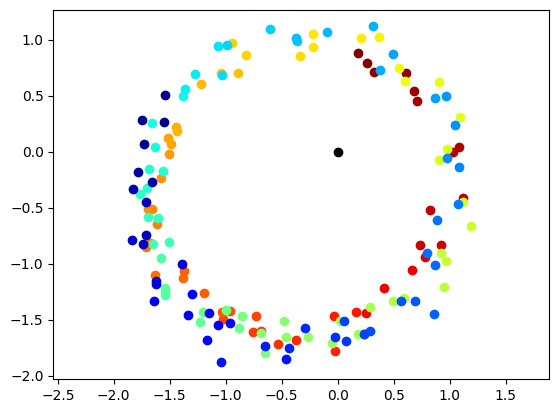

[array([0.89833241, 1.37185266]), array([0.83326132, 1.24846372]), array([0.78176376, 1.14746074]), array([0.92751718, 0.85285743]), array([0.86665273, 0.67303115])]


In [35]:
pos_sample = [pos + np.random.normal(0, 0.1, 2) for pos in pos_real[::20]]
plot2d(pos_sample)
polor_sample = [np.array(
    [np.linalg.norm(pos), np.arctan2(pos[1], pos[0])]) for pos in pos_sample]
t_sample = t_real[::20]
print(polor_sample[:5])

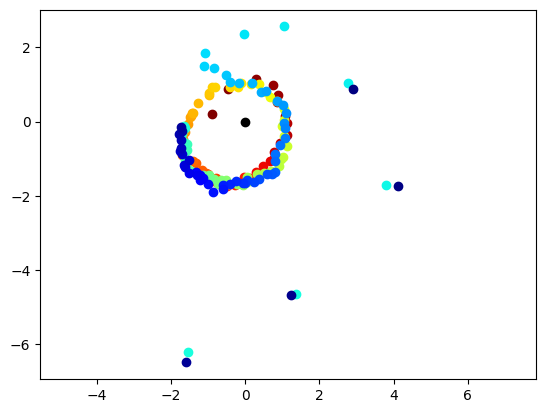

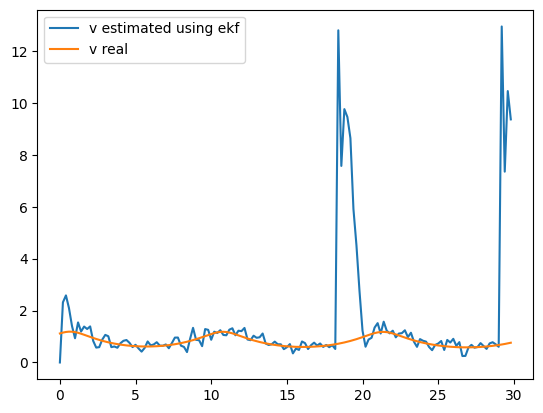

In [44]:
# state: x, y, vx, vy
# known: GM
# obs: r, theta
# predict will consider acceleration
# used in kalman
def predict_func_with_dt(dt):
    def predict_func(x: torch.Tensor):
        pos = x[:2]
        v = x[2:]
        a = -GM * pos / torch.norm(pos) ** 3
        nxt_v = v + a * dt
        return torch.cat((pos + (v + nxt_v) / 2 * dt, nxt_v))
    return predict_func


def measure_func(x: torch.Tensor):
    pos = x[:2]
    return torch.stack((torch.norm(pos), torch.atan2(pos[1], pos[0])))


ekf = Ekf(
    torch.tensor([-1., 0., 0., 0.]),
    torch.tensor([[1e6, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0]]),
    measure_func
)
pos_ekf = []
pos_v_ekf = []
for i in range(len(polor_sample)):
    ekf.predict(predict_func_with_dt(t_sample[i] - t_sample[i - 1] if i > 0 else 0), torch.tensor(
        [[0.1, 0, 0, 0], [0, 0.1, 0, 0], [0, 0, 10., 0], [0, 0, 0, 10.]]))
    ekf.update(torch.tensor(
        polor_sample[i], dtype=torch.float32), torch.tensor([[2, 0], [0, 0.8]]))
    pos_ekf.append(ekf.x[:2].detach().numpy())
    pos_v_ekf.append(ekf.x[2:].detach().numpy())

plot2d(pos_ekf)
# show v and v_real
plot_tuple([(t_sample, [np.linalg.norm(v) for v in pos_v_ekf], 'v estimated using ekf'),
           (t_real[::20], [np.linalg.norm(v) for v in v_real[::20]], 'v real')])

In [48]:
# What's going on here?
def closest_angle(target, src):
    return target + (src - target + np.pi) % (2 * np.pi) - np.pi


closest_angle(4 * np.pi - 0.01, 0.01), closest_angle(-np.pi +
                                                     0.01, np.pi - 0.01)

(12.576370614359172, -3.151592653589793)

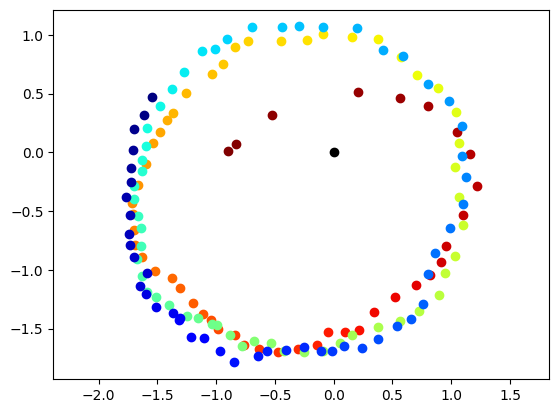

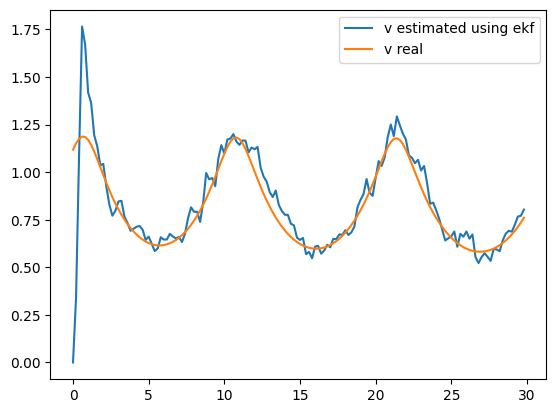

In [58]:
ekf = Ekf(
    torch.tensor([-1., 0., 0., 0.]),
    torch.tensor([[1e6, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0]]),
    measure_func
)
pos_ekf = []
pos_v_ekf = []
for i in range(len(polor_sample)):
    ekf.predict(
        predict_func_with_dt(t_sample[i] - t_sample[i - 1] if i > 0 else 0),
        Q=torch.tensor([[0.1, 0, 0, 0], [0, 0.1, 0, 0],
                       [0, 0, 10., 0], [0, 0, 0, 10.]])
    )
    pos = ekf.x[:2].detach().numpy()
    theta_close = closest_angle(np.arctan2(pos[1], pos[0]), polor_sample[i][1])
    ekf.update(
        z=torch.tensor((polor_sample[i][0], theta_close), dtype=torch.float32),
        R=torch.tensor([[40.0, 0], [0, 20]])
    )
    pos_ekf.append(ekf.x[:2].detach().numpy())
    pos_v_ekf.append(ekf.x[2:].detach().numpy())

plot2d(pos_ekf)
# show v and v_real
plot_tuple([(t_sample, [np.linalg.norm(v) for v in pos_v_ekf], 'v estimated using ekf'),
           (t_real[::20], [np.linalg.norm(v) for v in v_real[::20]], 'v real')])